In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
import numpy as np


# Universal import block 
# Block to get the relative imports working 
import os
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import config
import matplotlib.pyplot as plt 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import utils.pytorch_utils as utils
import utils.image_utils as img_utils
import cifar10.cifar_loader as cifar_loader
import cifar10.cifar_resnets as cifar_resnets
import adversarial_attacks as aa
import adversarial_training as advtrain
import adversarial_evaluation as adveval
import utils.checkpoints as checkpoints
import adversarial_perturbations as ap
import adversarial_attacks_refactor as aar 
import spatial_transformers as st 
reload(ap)

<module 'adversarial_perturbations' from '/Users/jordanm/grad/mister_ed/adversarial_perturbations.pyc'>

In [2]:
# Load up dataLoader, classifier, normer 
use_gpu = torch.cuda.is_available()
classifier_net = cifar_loader.load_pretrained_cifar_resnet(flavor=32,
                                                           use_gpu=use_gpu)
classifier_net.eval()

val_loader = cifar_loader.load_cifar_data('val', normalize=False, 
                                          batch_size=4, use_gpu=use_gpu)

cifar_normer = utils.DifferentiableNormalize(mean=config.CIFAR10_MEANS,
                                             std=config.CIFAR10_STDS)

examples, labels = next(iter(val_loader))


Files already downloaded and verified


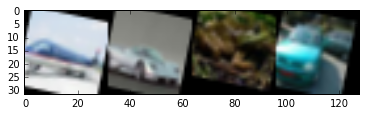

In [3]:
reload(ap)
reload(aar)
reload(st)
reload(utils)
import torchvision.transforms as transforms

# test block to assert we can initialize all the objects in adversarial perturbation 

delta_threat = ap.ThreatModel(ap.DeltaAddition, 
                              ap.PerturbationParameters(lp_style='inf',
                                                        lp_bound=8.0 / 255.0))

delta_perturbation = delta_threat(examples)
delta_perturbation.add_to_params(0.4)


rot_threat = ap.ThreatModel(ap.ParameterizedXformAdv, 
                            ap.PerturbationParameters(xform_class=st.RotationTransform, 
                                                      lp_style='inf',
                                                      lp_bound=0.2))
rot_pert = rot_threat(examples)
rot_pert.add_to_params(-0.2)
img_utils.show_images(rot_pert(Variable(examples)).data)


#img_utils.show_images(delta_perturbation(Variable(examples)).data)



#atk = aar.FGSM(classifier_net, cifar_normer, delta_threat, plf.VanillaXentropy(classifier_net, cifar_normer))
#foo = atk.attack(examples, labels)

#img_utils.show_images(foo(Variable(examples)).data - foo.originals + 0.5)



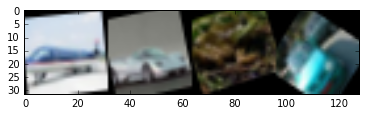

In [4]:

# rotation threat 
affine_threat = ap.ThreatModel(ap.ParameterizedXformAdv, 
                               ap.PerturbationParameters(lp_style='inf',
                                                         lp_bound=1.0,
                                                         xform_class=st.RotationTransform))

# translation threat 
trans_threat = ap.ThreatModel(ap.ParameterizedXformAdv, 
                              ap.PerturbationParameters(lp_style=1, 
                                                        lp_bound=0.2, 
                                                        xform_class=st.TranslationTransform))

# sequential threat 
sequence_threat = ap.ThreatModel(ap.SequentialPerturbation, 
                                 [affine_threat, delta_threat])


affine_perturb = affine_threat()
affine_perturb.setup(Variable(examples))

affine_perturb.add_to_params(torch.Tensor([0.1, 0.2, 0.3, 1]))

trans_perturb = trans_threat()
trans_perturb.setup(Variable(examples))
trans_perturb.add_to_params(torch.Tensor([[0.1, 0.1], [0.2, 0.2], [-0.5, -0.5], [0, 0.75]]))


sequence_threat = ap.ThreatModel(ap.SequentialPerturbation, 
                                 [affine_threat, trans_threat])
sequence_perturb = sequence_threat()
sequence_perturb.setup(examples)
sequence_perturb.pipeline[0].add_to_params(torch.Tensor([0.1, 0.2, 0.3, 1]))
sequence_perturb.pipeline[1].add_to_params(torch.Tensor([[0.1, 0.1], [0.2, 0.2], [-0.5, -0.5], [0, 0.75]]))

#centercrop = transforms.CenterCrop(10)
#print dir(centercrop)
#img_utils.show_images(nn.ConstantPad2d(10, 0)(examples).data)
# print transforms.Pad(10)(examples)
#img_utils.show_images(transforms.Pad(10))
img_utils.show_images(affine_perturb.forward(Variable(examples)).data)



(Post FGSM):  25.0 correct


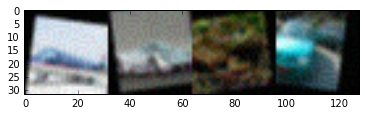

In [5]:
reload(ap)
reload(aar)
import math
pp = ap.PerturbationParameters(lp_style='inf', lp_bound=8.0/255.0)
delta_threat = ap.ThreatModel(ap.DeltaAddition, pp)

rotation_threat = ap.ThreatModel(ap.ParameterizedXformAdv,
                                 ap.PerturbationParameters(xform_class=st.RotationTransform, 
                                                          lp_style='inf', lp_bound=math.pi / 24.))

translation_threat = ap.ThreatModel(ap.ParameterizedXformAdv, 
                                    ap.PerturbationParameters(xform_class=st.TranslationTransform, 
                                                              lp_style=1, lp_bound=0.2))
rotation_delta_threat = ap.ThreatModel(ap.SequentialPerturbation, 
                                       [rotation_threat, translation_threat, delta_threat])


import adversarial_attacks_refactor as aar 
atk = aar.FGSM(classifier_net, cifar_normer, rotation_delta_threat, plf.VanillaXentropy(classifier_net, cifar_normer))
foo = atk.attack(examples, labels, step_size=1)


img_utils.show_images(foo.forward(Variable(examples)).data)
#print torch.sum(foo.pipeline[0].delta)

# delta = foo.pipeline[0].delta

# print delta
#foo.constrain_params()
#print foo.pipeline[0].delta

#img_utils.show_images(foo.pipeline[0].adversarial_tensors())
#img_utils.show_images(foo.pipeline[0].adversarial_tensors())

# img_utils.show_images(foo.adversarial_tensors())

(START):  100.0 correct
(iteration 00):  100.0 correct
(iteration 01):  100.0 correct
(iteration 02):  100.0 correct
(iteration 03):  100.0 correct
(iteration 04):  100.0 correct
(iteration 05):  100.0 correct
(iteration 06):  100.0 correct
(iteration 07):  100.0 correct
(iteration 08):  100.0 correct
(iteration 09):  100.0 correct
(iteration 10):  100.0 correct
(iteration 11):  100.0 correct
(iteration 12):  100.0 correct
(iteration 13):  100.0 correct
(iteration 14):  100.0 correct
(iteration 15):  100.0 correct
(iteration 16):  75.0 correct
(iteration 17):  75.0 correct
(iteration 18):  75.0 correct
(iteration 19):  75.0 correct
(iteration 20):  75.0 correct
(iteration 21):  75.0 correct
(iteration 22):  75.0 correct
(iteration 23):  75.0 correct
(iteration 24):  75.0 correct
(iteration 25):  75.0 correct
(iteration 26):  75.0 correct
(iteration 27):  75.0 correct
(iteration 28):  75.0 correct
(iteration 29):  75.0 correct
(iteration 30):  75.0 correct
(iteration 31):  75.0 correct


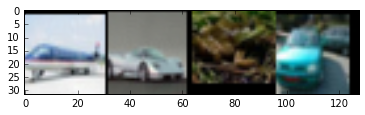

In [6]:
reload(ap)
reload(aar)
reload(st)
reload(utils)

pp = ap.PerturbationParameters(lp_style='inf', lp_bound=8.0/255.0)
delta_threat = ap.ThreatModel(ap.DeltaAddition, pp)


pgd_attack = aar.PGD(classifier_net, cifar_normer, delta_threat,  plf.VanillaXentropy(classifier_net, cifar_normer))
foo = pgd_attack.attack(examples, labels, random_init=False, num_iterations=50, signed=False, verbose=True)
img_utils.show_images(foo.adversarial_tensors())

In [10]:
reload(ap)
reload(lf)
print type(foo)
print isinstance(foo, ap.DeltaAddition)


<class 'adversarial_perturbations.DeltaAddition'>
False


AssertionError: 

In [ ]:
# Now make a PGD attack with a threat model that allows for small rotations and perturbations 

reload(ap)
pp = ap.PerturbationParameters(lp_style='inf', lp_bound=2.0/255.0)
delta_threat = ap.ThreatModel(ap.DeltaAddition, pp)

rot_pp = ap.PerturbationParameters(xform_class=st.RotationTransform, 
                                   lp_style='inf', lp_bound=math.pi/24.0                                  )
rot_threat = ap.ThreatModel(ap.ParameterizedXformAdv, rot_pp)


flow_pp = ap.PerturbationParameters(xform_class=st.FullSpatial, 
                                    lp_style='inf', lp_bound=1.0 / 320)
flow_threat = ap.ThreatModel(ap.ParameterizedXformAdv, flow_pp)


sequential_threat = ap.ThreatModel(ap.SequentialPerturbation, 
                                   [flow_threat, delta_threat])

pgd_attack = aar.PGD(classifier_net, cifar_normer, sequential_threat,  plf.VanillaXentropy(classifier_net, cifar_normer))
foo = pgd_attack.attack(examples, labels, random_init=True, signed=True, verbose=True)

# img_utils.show_images(foo.originals)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

img_utils.show_images(foo.adversarial_tensors())


In [ ]:
reload(ap)
reload(aar)
reload(st)

# Make a threat model that allows for sequential perturbation 
# 



threat_list = [ap.ThreatModel(ap.ParameterizedXformAdv,
                              ap.PerturbationParameters(lp_style='inf', lp_bound=0.01,
                                                        xform_class=st.FullSpatial)),
               ap.ThreatModel(ap.DeltaAddition, 
                              ap.PerturbationParameters(lp_style='inf', lp_bound=4.0/255.0)),
               ap.ThreatModel(ap.DeltaAddition, 
                               ap.PerturbationParameters(lp_style='inf', lp_bound=0.0/255.0))
               ]
threat = ap.ThreatModel(ap.SequentialPerturbation, 
                        threat_list[:])
 

#foo(examples)
atk = aar.FGSM(classifier_net, cifar_normer, threat, plf.VanillaXentropy(classifier_net, cifar_normer))


foo = atk.attack(examples, labels, step_size=0.5)
foo.constrain_params()
print torch.max(torch.abs(foo().data))
img_utils.show_images(foo().data)



In [ ]:
""" Okay first order of business is to assert that merge perturbations works"""
reload(ap)
pp = ap.PerturbationParameters(lp_style='inf', lp_bound=1)
delta_threat = ap.ThreatModel(ap.DeltaAddition, pp)
delta_1 = delta_threat(examples) 
delta_2 = delta_threat(examples) 
delta_1.add_to_params(+0.4)
delta_2.add_to_params(-0.4)

merge_params = torch.ByteTensor(4)
merge_params[0] = 1
merge_params[3] = 1 
# bright on the left and right
delta_merge = delta_1.merge_perturbation(delta_2, merge_params)

print delta_1.delta[:, 0, 0, 0]
print delta_2.delta[:, 0, 0, 0]
print delta_merge.delta[:,0,0,0]
print type(examples)
print type(delta_1.forward(Variable(examples)).data)



In [ ]:
""" Next is to show that transformations can be merged appropriately """
reload(ap)
reload(st)
rot_pp = ap.PerturbationParameters(lp_style='inf', lp_bound=1, 
                                   xform_class=st.RotationTransform)
rot_threat = ap.ThreatModel(ap.ParameterizedXformAdv, rot_pp)
rot_1 = rot_threat(examples) 
rot_2 = rot_threat(examples)

rot_1.add_to_params(0.5) # CCW
rot_2.add_to_params(-0.5) #CW 
print rot_1.xform.__class__.__bases__[0].__bases__

merge_params = torch.ByteTensor(4)
merge_params[0] = 1
merge_params[3] = 1
# CCW on the bookends, CW in the middle
rot_merge = rot_1.merge_perturbation(rot_2, merge_params)
img_utils.show_images(rot_merge(Variable(examples)).data)


In [ ]:
""" Next is to show that transformations can be merged appropriately """
reload(ap)
reload(st)

# Make a sequential perturbation 
delta_pp = ap.PerturbationParameters(lp_style='inf', lp_bound=1)
delta_threat = ap.ThreatModel(ap.DeltaAddition, delta_pp)

rot_pp = ap.PerturbationParameters(lp_style='inf', lp_bound=1, 
                                   xform_class=st.RotationTransform)
rot_threat = ap.ThreatModel(ap.ParameterizedXformAdv, rot_pp)
rot_1 = rot_threat(examples) 
rot_2 = rot_threat(examples)

rot_1.add_to_params(0.5) # CCW
rot_2.add_to_params(-0.5) #CW 
print rot_1.xform.__class__.__bases__[0].__bases__

merge_params = torch.ByteTensor(4)
merge_params[0] = 1
merge_params[3] = 1
# CCW on the bookends, CW in the middle
rot_merge = rot_1.merge_perturbation(rot_2, merge_params)


# And make a sequential perturbation:
sequential_threat = ap.ThreatModel(ap.SequentialPerturbation, 
                                   [rot_threat, delta_threat])

seq_1 = sequential_threat(examples)
seq_1.pipeline[1].add_to_params(0.5)
seq_1.pipeline[0].add_to_params(0.5)

seq_2 = sequential_threat(examples)
seq_2.pipeline[1].add_to_params(-0.5)
seq_2.pipeline[0].add_to_params(-0.5)

merge_params = torch.ByteTensor(4)
merge_params[0] = 1
merge_params[3] = 1
seq_merge = seq_1.merge_perturbation(seq_2, merge_params)

img_utils.show_images(seq_merge.forward(Variable(examples)).data)
#img_utils.show_images(seq_1(Variable(examples)).data)


In [ ]:
# Now with merges working, try to build a carlini wagner attack 
reload(aar)
reload(lf)
reload(ap)
reload(utils)
delta_pp = ap.PerturbationParameters(lp_style='inf', lp_bound=64.0/255)
delta_threat = ap.ThreatModel(ap.DeltaAddition, delta_pp)

# CW LOSS FXNS
cw_distance = lf.L2Regularization
cw_adv_loss = lf.CWLossF6

cw = aar.CarliniWagner(classifier_net, cifar_normer, delta_threat, cw_distance, 
                       cw_adv_loss)

out = cw.attack(examples, labels,  initial_lambda=64.0)

In [ ]:
out.distances
out.
